In [1]:
# 1. Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib, json


In [2]:
# 2. Load dataset
df = pd.read_csv('blood.csv')
print('Loaded blood.csv — shape:', df.shape)
df.head()

Loaded blood.csv — shape: (748, 5)


,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,99,1
1,0,13,3250,28,1
2,1,17,4000,36,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [3]:
# 3. Data overview
print('\nInfo:') 
display(df.info())
print('\nMissing values per column:')
display(df.isnull().sum())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


None


Missing values per column:


Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64

In [4]:
# 4. Data cleaning & encoding
# Drop rows with missing values (simple, conservative)
df = df.dropna().reset_index(drop=True)

# Label-encode object columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print('\nEncoded columns:', list(label_encoders.keys()))
display(df.head())


Encoded columns: []


,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,99,1
1,0,13,3250,28,1
2,1,17,4000,36,1
3,2,20,5000,45,1
4,1,24,6000,77,0


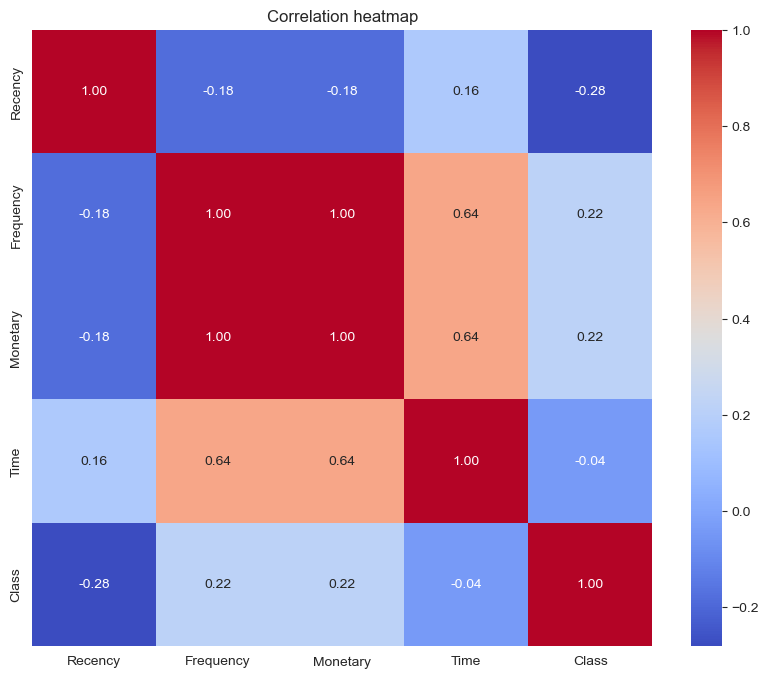

C:\Users\91960\AppData\Local\Temp\ipykernel_9848\2579583538.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette='viridis')


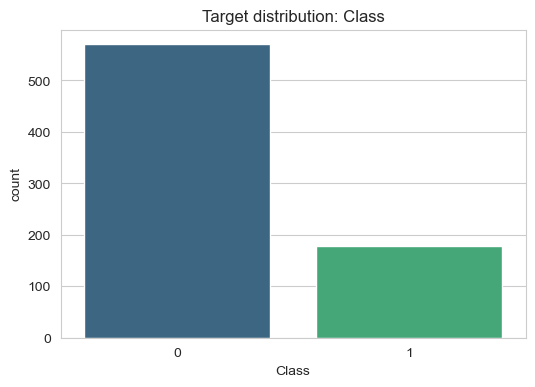

C:\Users\91960\AppData\Local\Temp\ipykernel_9848\2579583538.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette='Set2')


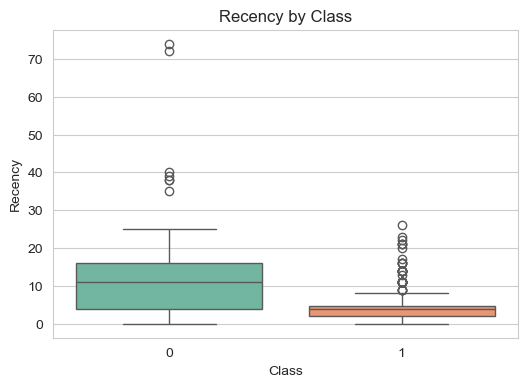

C:\Users\91960\AppData\Local\Temp\ipykernel_9848\2579583538.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette='Set2')


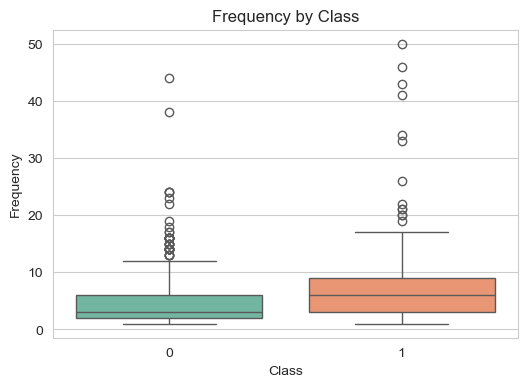

C:\Users\91960\AppData\Local\Temp\ipykernel_9848\2579583538.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette='Set2')


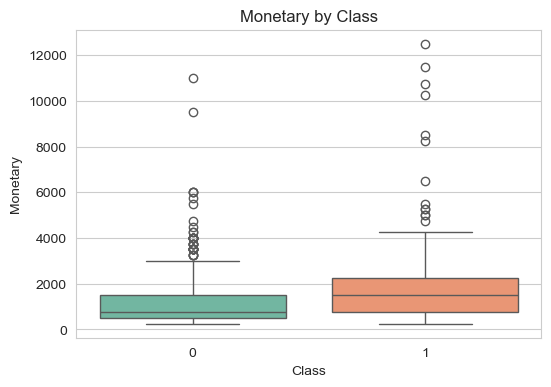

C:\Users\91960\AppData\Local\Temp\ipykernel_9848\2579583538.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=col, data=df, palette='Set2')


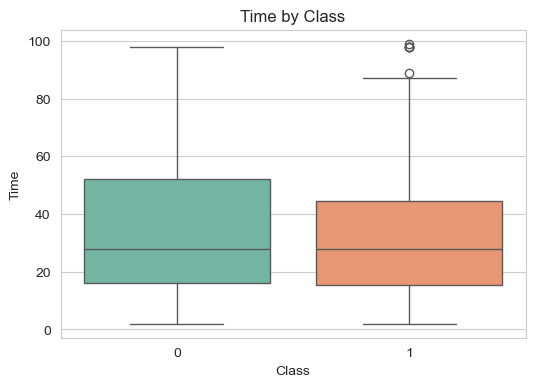

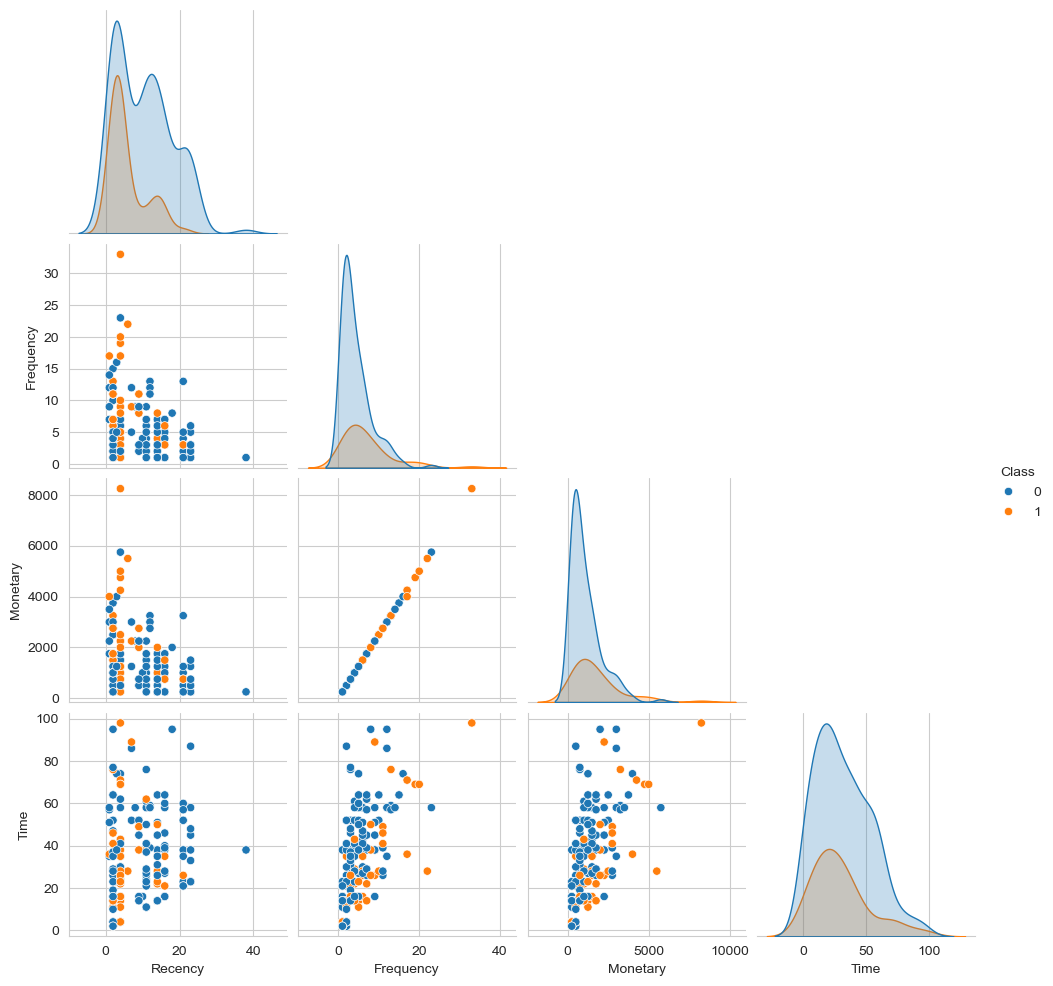

In [5]:
# 5. Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation heatmap')
plt.show()

# Target distribution
target_col = df.columns[-1]
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df, palette='viridis')
plt.title(f'Target distribution: {target_col}')
plt.show()

# Boxplots of numeric features vs target
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c != target_col]
for col in num_cols[:8]:  # limit plots for readability
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y=col, data=df, palette='Set2')
    plt.title(f'{col} by {target_col}')
    plt.show()

# Pairplot (sampled for speed)
sample_df = df.sample(min(200, len(df)), random_state=42)
sns.pairplot(sample_df, hue=target_col, diag_kind='kde', corner=True)
plt.show()

In [7]:
# 6. Features & target split
X = df.iloc[:, :-1].copy()
y = df.iloc[:, -1].copy()
print('Feature matrix X shape:', X.shape)
print('Target y distribution:')
display(y.value_counts(normalize=True))

Feature matrix X shape: (748, 4)
Target y distribution:


Class
0    0.762032
1    0.237968
Name: proportion, dtype: float64

In [8]:
# 7. Train-test split & scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [9]:
# 8. Train multiple models and evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
}

results = []
fitted_models = {}

for name, m in models.items():
    m.fit(X_train_s, y_train)
    preds = m.predict(X_test_s)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted', zero_division=0)
    rec = recall_score(y_test, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0)
    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})
    fitted_models[name] = m
    
results_df = pd.DataFrame(results).sort_values('F1', ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1
0,Gradient Boosting,0.813333,0.802155,0.813333,0.804831
1,Random Forest,0.746667,0.732667,0.746667,0.738399
2,Logistic Regression,0.766667,0.727073,0.766667,0.701149


C:\Users\91960\AppData\Local\Temp\ipykernel_9848\3036814693.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1', data=results_df, palette='magma')


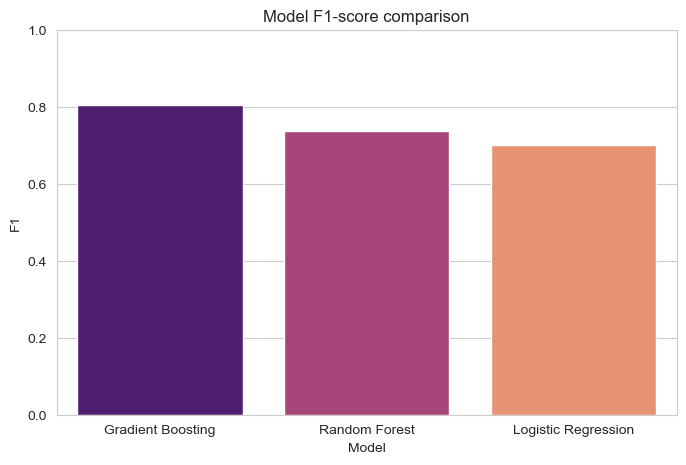

In [10]:
# 9. Visual comparison of models (F1 score)
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='F1', data=results_df, palette='magma')
plt.title('Model F1-score comparison')
plt.ylim(0,1)
plt.show()

Best model: Gradient Boosting

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       114
           1       0.64      0.50      0.56        36

    accuracy                           0.81       150
   macro avg       0.75      0.71      0.72       150
weighted avg       0.80      0.81      0.80       150



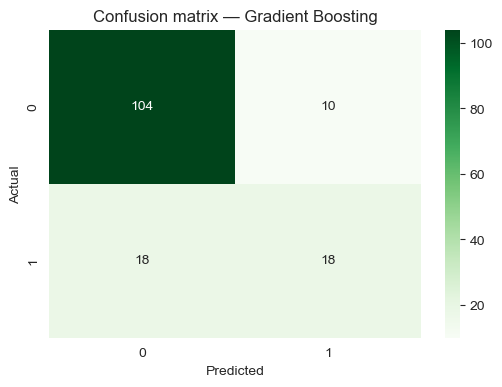

In [11]:
# 10. Best model diagnostics
best_name = results_df.loc[0, 'Model']
best_model = fitted_models[best_name]
print('Best model:', best_name)

y_pred = best_model.predict(X_test_s)
print('\nClassification report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion matrix — {best_name}')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

In [12]:
# 11. Save best model and feature order (for Streamlit)
import joblib, json
joblib.dump(best_model, 'best_model.pkl', compress=3)
FEATURES = list(X.columns)
with open('feature_order.json', 'w', encoding='utf-8') as f:
    json.dump(FEATURES, f, indent=2)
print('Saved best_model.pkl and feature_order.json')

Saved best_model.pkl and feature_order.json


In [13]:
# 12. Demo prediction using the saved pipeline
sample = X_test_s[0].reshape(1, -1)
print('Sample shape:', sample.shape)
print('Predicted class (best model):', best_model.predict(sample)[0])

Sample shape: (1, 4)
Predicted class (best model): 1
